# T-SNE on Amazon fine food dataset

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

#### Objective:
t-SNE visualization of Amazon reviews with polarity based color-coding

## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [35]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



# using the SQLite Table to read data.
con = sqlite3.connect('E:/Applied AI material/10. Amazon fine food reviews data/database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [36]:
#looking at the number of attributes and size of the data
print(filtered_data.shape) 
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


###  Exploratory Data Analysis

#### Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [37]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [38]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [39]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [40]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [41]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [42]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [43]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

#### Working on Sample dataset

In [52]:
#Appending negative and positive data.
final =final.sample(n=5000)
final.shape

(5000, 11)

In [53]:
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
423811,458357,B00158U8DU,A3ITJENRZ12J4Q,NaturalChi,1,1,positive,1327881600,happy I bought this!,After I first used this bag I wondered how I e...,first use bag wonder ever bother make nut milk...
93946,102134,B0030F5NBI,AYJTC77G0FUQS,Erin,2,2,negative,1302480000,nasty Texture and blah flavor,I bought these because they were on sale. I th...,bought sale thought itd tast like tuna salad c...
280018,303418,B007OY1UR2,AZEJLR43KBR8G,Robert Becker,1,1,positive,1349481600,"Great Coffee, has become our daily cup",A great simple and smooth brew of coffee. We h...,great simpl smooth brew coffe made daili choic...
173535,188237,B0027Z8VES,ADK2VA0ZGWEV6,Shayne,1,2,negative,1335916800,Burnt Taste,My order arrived today and I immediately made ...,order arriv today immedi made cup bean horribl...
13338,14563,B0032BXUJM,A3CJNM7X4KOFCE,"Lynne E. Curtin ""Lindy""",0,0,positive,1312848000,Lindy,My favorite so far. Bold but smooth with no b...,favorit far bold smooth bitter tast high recom...


In [54]:
final['Score'].value_counts()

positive    4201
negative     799
Name: Score, dtype: int64

### Text Preprocessing: Stemming, stop-word removal and Lemmatization.
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags
Remove any punctuations or limited set of special characters like , or . or # etc.
Check if the word is made up of english letters and is not alpha-numeric
Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
Convert the word to lowercase
Remove Stopwords
Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
After which we collect the words used to describe positive and negative reviews

In [55]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

0
After I first used this bag I wondered how I ever bothered making nut milk before. The process is so much easier and effective now! Through this bag I am able to squeeze out more "nut" which results in a much richer tasting milk. Furthermore I am done in about 3 minutes, as opposed to approx. 10 minutes it used to take me to hand press through a regular kitchen sieve.<br /><br />So, yep, very happy I bought this!


In [56]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\deepak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [57]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{"didn't", "hasn't", 'don', 'won', 'most', 'here', 'what', 'both', 'yourselves', "don't", 'haven', 'is', 'just', 'at', 'down', 'with', 'shouldn', 'if', 'then', "mustn't", 'shan', 'such', "you've", 'd', 'some', 'all', 'needn', 't', 'over', 'after', 's', 'ma', 'own', 'were', 'until', 'should', 'they', 'before', "needn't", 'whom', 'have', 'or', 'more', 'the', "should've", "you'll", 'out', 'me', 'up', "mightn't", 'only', 'this', 'having', 'hadn', 'didn', 'weren', 'against', 'but', 'while', "you're", 'because', 'she', "that'll", 'during', 'y', 'does', 'there', 'he', 'from', 'now', "hadn't", 'been', 'you', 'than', "haven't", 'his', 'we', 'on', 'yours', 'where', 'mightn', 'mustn', "weren't", 'below', 'when', 'any', 'once', 'few', "it's", 'above', 'between', 'it', 'no', "you'd", 'why', 'your', 'hers', 'herself', 'be', "aren't", 'had', 'by', "won't", 'as', 'wasn', 'our', 'o', 'himself', "shouldn't", 'doing', 'those', 'am', 'can', 'further', 'of', 'did', "she's", 'an', 'being', 're', 'to', 'are'

In [58]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [59]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [60]:
final.head(3) #below the processed review can be seen in the CleanedText Column 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
423811,458357,B00158U8DU,A3ITJENRZ12J4Q,NaturalChi,1,1,positive,1327881600,happy I bought this!,After I first used this bag I wondered how I e...,first use bag wonder ever bother make nut milk...
93946,102134,B0030F5NBI,AYJTC77G0FUQS,Erin,2,2,negative,1302480000,nasty Texture and blah flavor,I bought these because they were on sale. I th...,bought sale thought itd tast like tuna salad c...
280018,303418,B007OY1UR2,AZEJLR43KBR8G,Robert Becker,1,1,positive,1349481600,"Great Coffee, has become our daily cup",A great simple and smooth brew of coffee. We h...,great simpl smooth brew coffe made daili choic...


In [61]:
final.shape

(5000, 11)

## Bag of Words (BoW)

##### Simple BOW

In [78]:
#BoW
count_vect = CountVectorizer(min_df=5) #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 2933)
the number of unique words  2933


In [79]:
#Converting sparse matrix to dense
final_counts=final_counts.toarray()

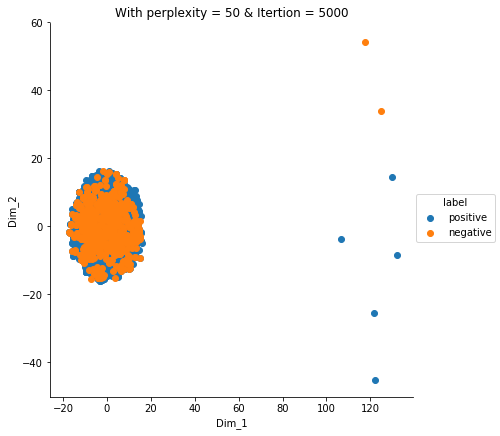

In [80]:
#Trying with 50 perplexity and 5000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=50,n_iter=5000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50 & Itertion = 5000')
plt.show()

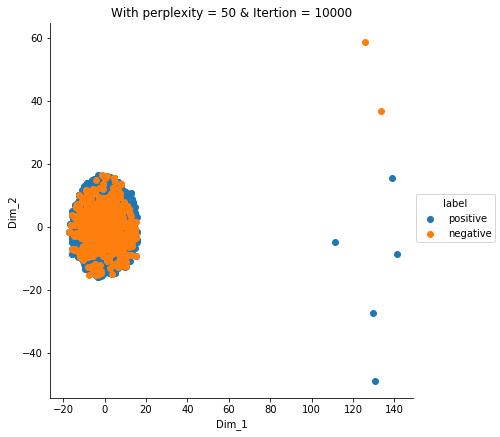

In [81]:
#Trying with 50 perplexity and 10000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=50,n_iter=10000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50 & Itertion = 10000')
plt.show()

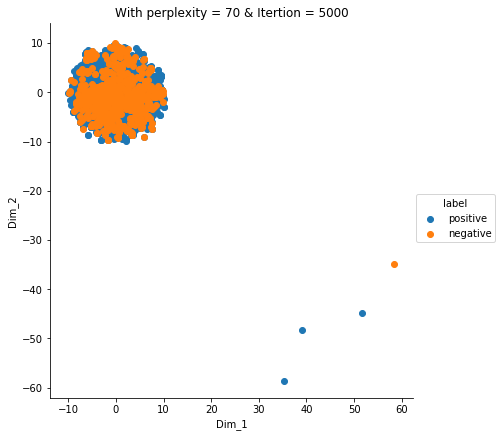

In [82]:
#Trying with 70 perplexity and 5000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=70,n_iter=5000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 70 & Itertion = 5000')
plt.show()

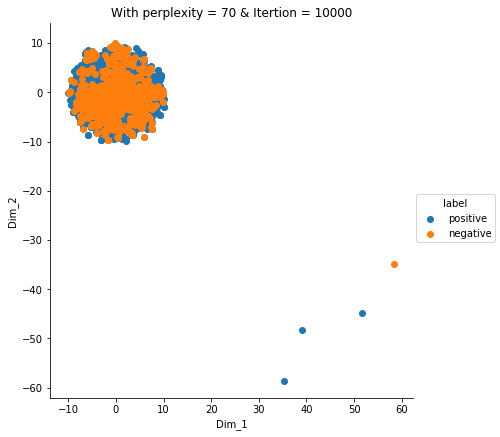

In [83]:
#Trying with 70 perplexity and 10000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=70,n_iter=10000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 70 & Itertion = 10000')
plt.show()

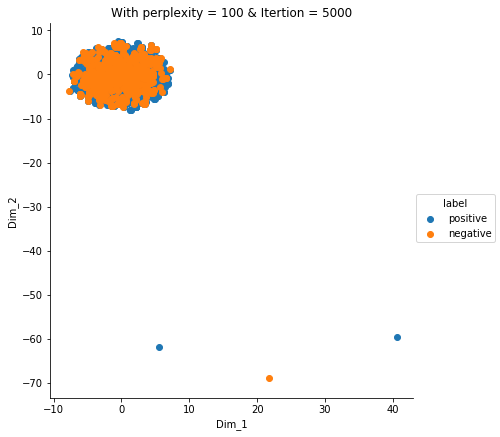

In [84]:
#Trying with 100 perplexity and 5000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=100,n_iter=5000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 100 & Itertion = 5000')
plt.show()

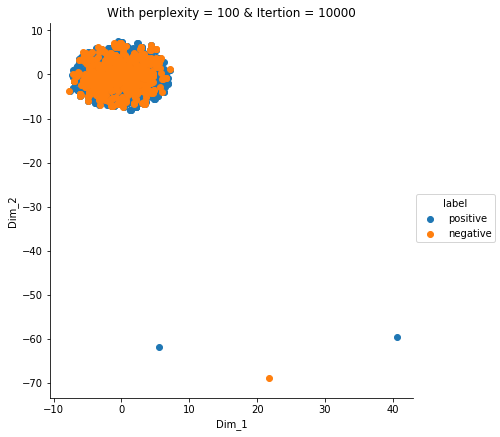

In [85]:
#Trying with 100 perplexity and 10000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=100,n_iter=10000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 100 & Itertion = 10000')
plt.show()

##### Binary BOW

In [62]:
#Binary BoW
count_vect = CountVectorizer(binary=True,min_df=3) #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 4049)
the number of unique words  4049


In [63]:
#Converting sparse matrix to dense
final_counts=final_counts.toarray()

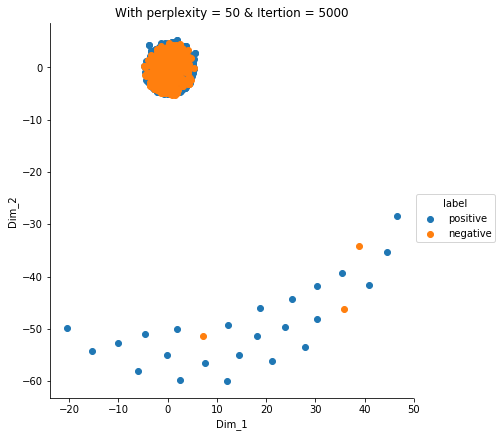

In [64]:
#Trying with 50 perplexity and 5000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=50,n_iter=5000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50 & Itertion = 5000')
plt.show()

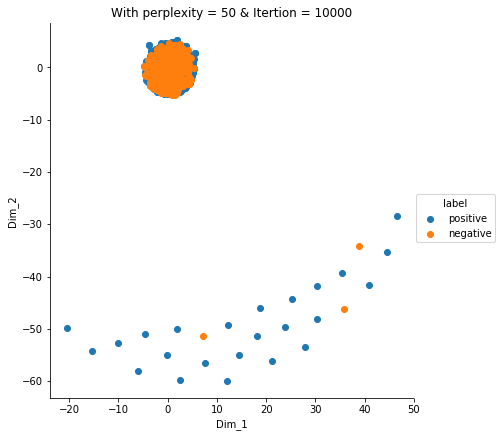

In [65]:
#Trying with 50 perplexity and 10000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=50,n_iter=10000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50 & Itertion = 10000')
plt.show()

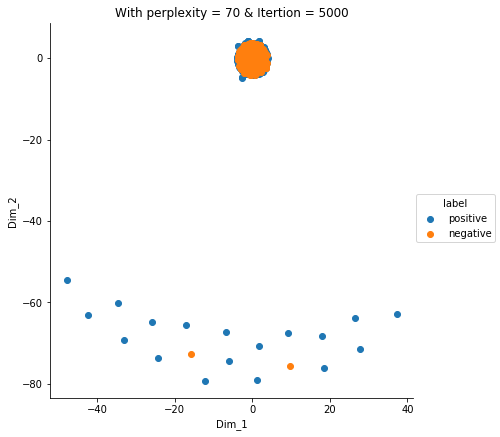

In [67]:
#Trying with 70 perplexity and 5000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=70,n_iter=5000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 70 & Itertion = 5000')
plt.show()

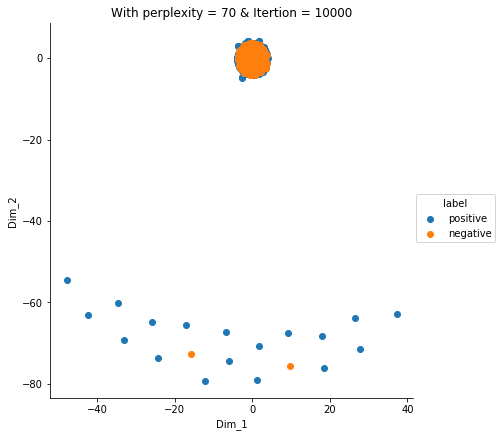

In [68]:
#Trying with 70 perplexity and 10000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=70,n_iter=10000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 70 & Itertion = 10000')
plt.show()

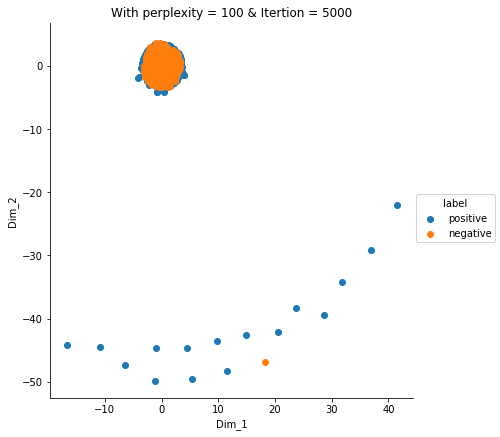

In [69]:
#Trying with 100 perplexity and 5000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=100,n_iter=5000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 100 & Itertion = 5000')
plt.show()

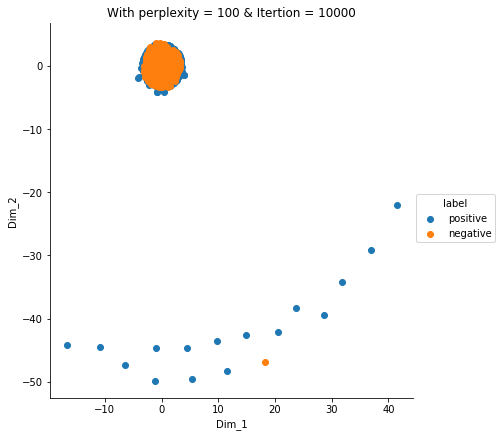

In [70]:
#Trying with 100 perplexity and 10000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=100,n_iter=10000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 100 & Itertion = 10000')
plt.show()

#### BOW bi-grams

In [71]:
#BoW
count_vect = CountVectorizer(binary=True,ngram_range=(1,2),min_df=5) #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 6467)
the number of unique words  6467


In [72]:
#Converting sparse matrix to dense
final_counts=final_counts.toarray()

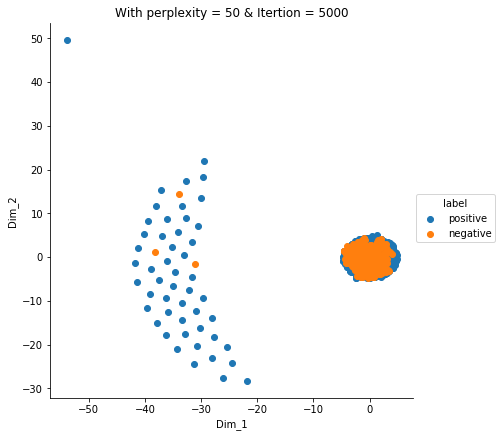

In [73]:
#Trying with 50 perplexity and 5000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=50,n_iter=5000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50 & Itertion = 5000')
plt.show()

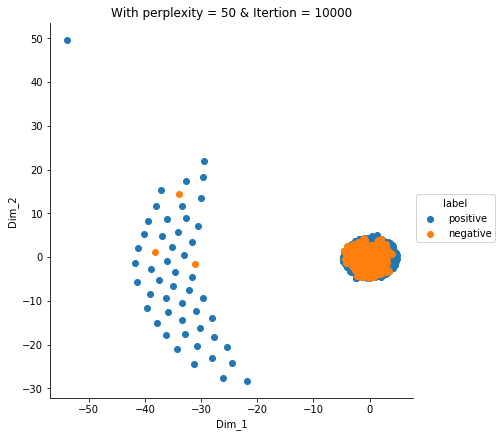

In [74]:
#Trying with 50 perplexity and 10000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=50,n_iter=10000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50 & Itertion = 10000')
plt.show()

## TF-IDF

##### Simple TF-IDF

In [87]:
#TFidf
tf_idf_vect = TfidfVectorizer(min_df=5) #in scikit-learn
final_counts = tf_idf_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 2933)
the number of unique words  2933


In [88]:
#Converting sparse matrix to dense
final_counts=final_counts.toarray()

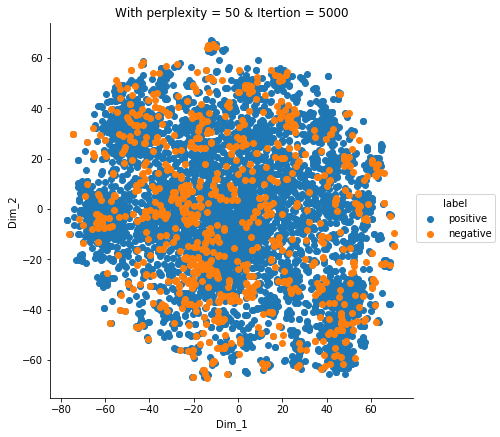

In [89]:
#Trying with 50 perplexity and 5000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=50,n_iter=5000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50 & Itertion = 5000')
plt.show()

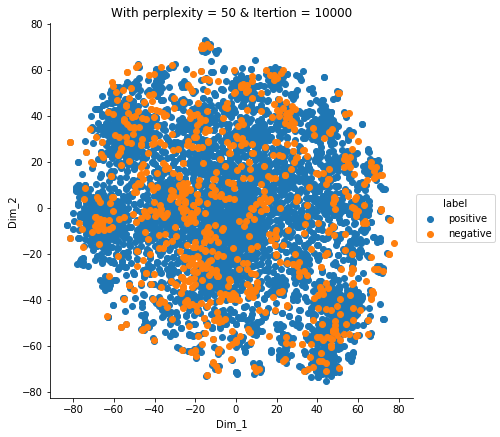

In [90]:
#Trying with 50 perplexity and 10000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=50,n_iter=10000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50 & Itertion = 10000')
plt.show()

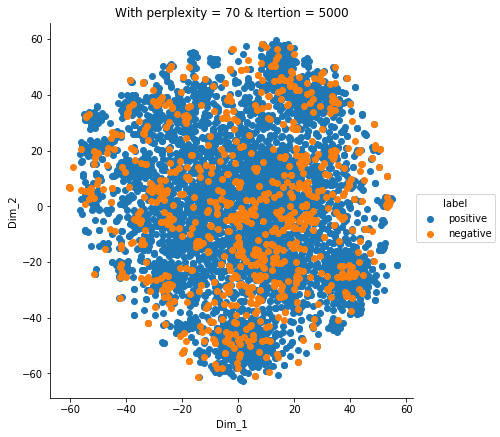

In [91]:
#Trying with 70 perplexity and 5000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=70,n_iter=5000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 70 & Itertion = 5000')
plt.show()

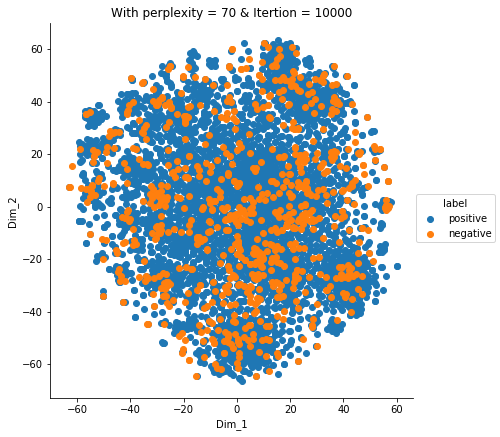

In [92]:
#Trying with 70 perplexity and 10000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=70,n_iter=10000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 70 & Itertion = 10000')
plt.show()

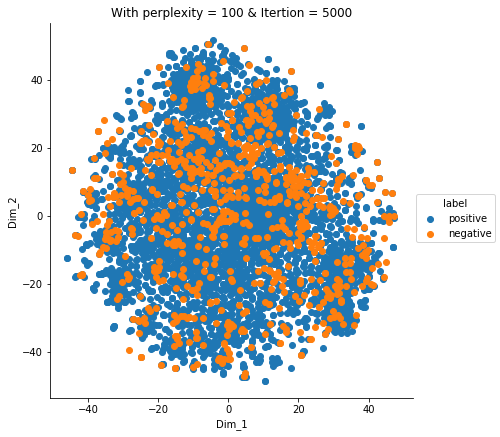

In [93]:
#Trying with 100 perplexity and 5000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=100,n_iter=5000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 100 & Itertion = 5000')
plt.show()

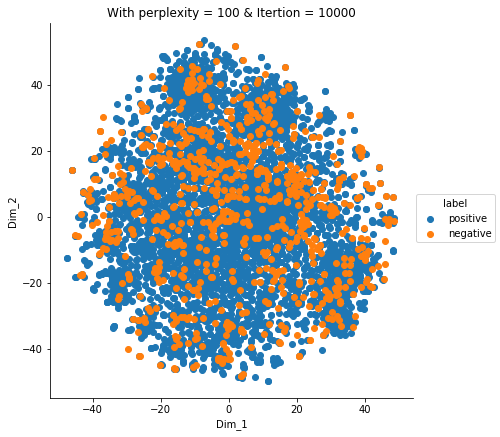

In [94]:
#Trying with 100 perplexity and 10000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=100,n_iter=10000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 100 & Itertion = 10000')
plt.show()

##### Binary TF-IDF

In [95]:
#TFidf
tf_idf_vect = TfidfVectorizer(binary=True,min_df=5) #in scikit-learn
final_counts = tf_idf_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 2933)
the number of unique words  2933


In [96]:
#Converting sparse matrix to dense
final_counts=final_counts.toarray()

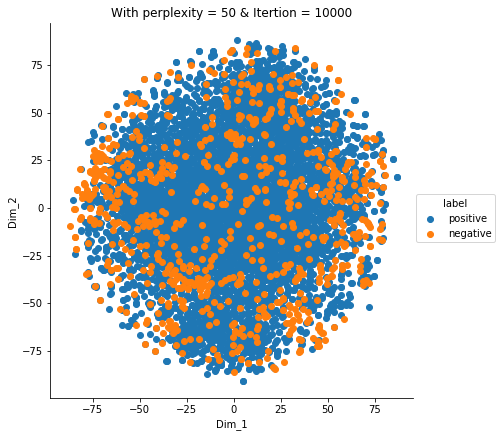

In [97]:
#Trying with 50 perplexity and 10000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=50,n_iter=10000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50 & Itertion = 10000')
plt.show()

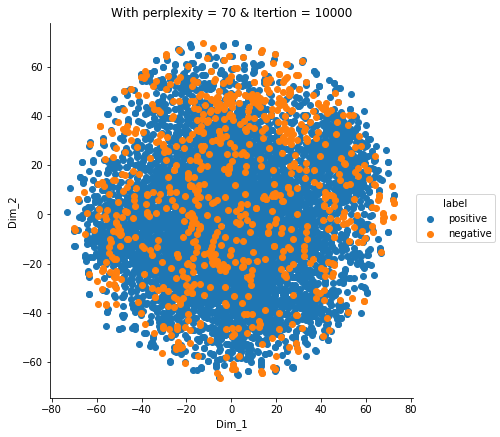

In [98]:
#Trying with 70 perplexity and 10000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=70,n_iter=10000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 70 & Itertion = 10000')
plt.show()

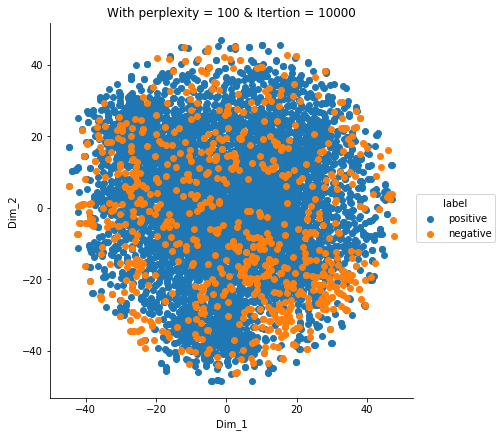

In [99]:
#Trying with 100 perplexity and 10000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=100,n_iter=10000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 100 & Itertion = 10000')
plt.show()

##### Bi-Gram Binary TF-IDF

In [100]:
#TFidf
tf_idf_vect = TfidfVectorizer(binary=True,min_df=5,ngram_range=(1,2)) #in scikit-learn
final_counts = tf_idf_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 6467)
the number of unique words  6467


In [101]:
#Converting sparse matrix to dense
final_counts=final_counts.toarray()

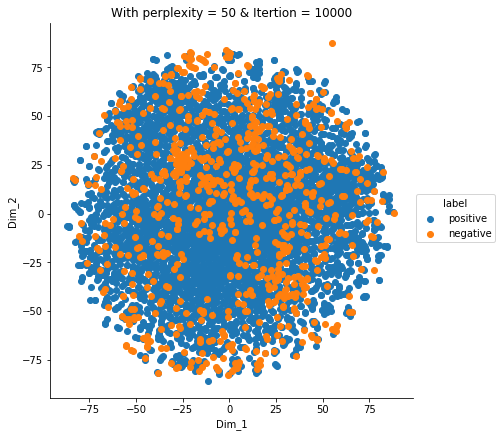

In [102]:
#Trying with 50 perplexity and 10000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=50,n_iter=10000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50 & Itertion = 10000')
plt.show()

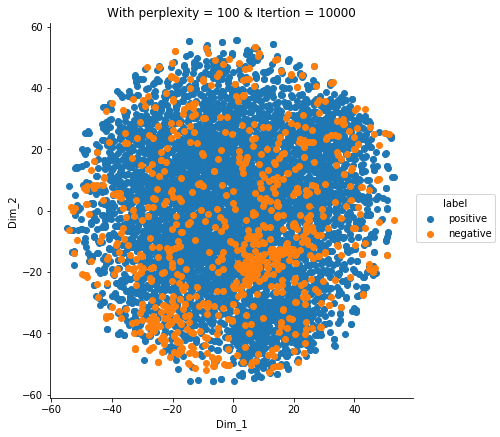

In [103]:
#Trying with 100 perplexity and 10000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=100,n_iter=10000)

tsne_data = model.fit_transform(final_counts)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 100 & Itertion = 10000')
plt.show()

## Word2Vec

In [104]:
# Train your own Word2Vec model using your own text corpus
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [105]:
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

first use bag wonder ever bother make nut milk process much easier effect bag abl squeez nut result much richer tast milk furthermor done minut oppos approx minut use take hand press regular kitchen siev yep happi bought
*****************************************************************
['first', 'use', 'bag', 'wonder', 'ever', 'bother', 'make', 'nut', 'milk', 'process', 'much', 'easier', 'effect', 'bag', 'abl', 'squeez', 'nut', 'result', 'much', 'richer', 'tast', 'milk', 'furthermor', 'done', 'minut', 'oppos', 'approx', 'minut', 'use', 'take', 'hand', 'press', 'regular', 'kitchen', 'siev', 'yep', 'happi', 'bought']


In [106]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [107]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  3240


#### Avg Word2Vec

In [108]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

5000
50


In [110]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(sent_vectors)
print(standardized_data.shape)

(5000, 50)


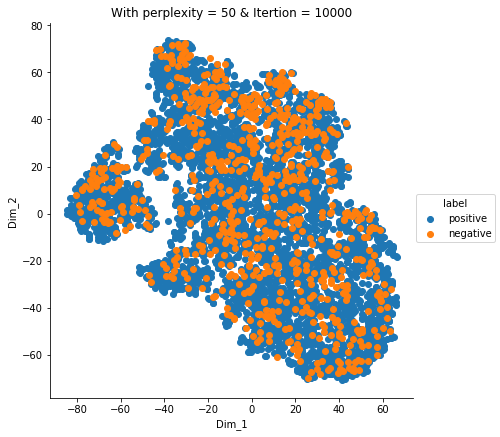

In [111]:
#Trying with 50 perplexity and 10000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=50,n_iter=10000)

tsne_data = model.fit_transform(standardized_data)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50 & Itertion = 10000')
plt.show()

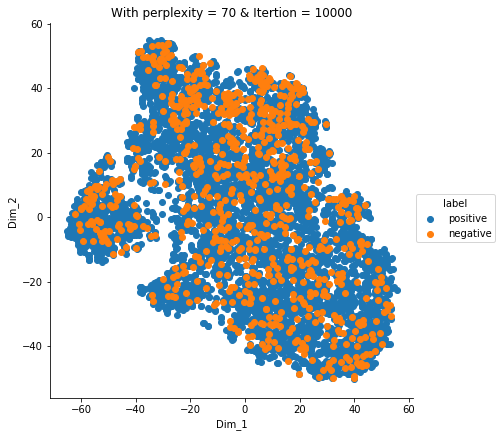

In [112]:
#Trying with 70 perplexity and 10000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=70,n_iter=10000)

tsne_data = model.fit_transform(standardized_data)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 70 & Itertion = 10000')
plt.show()

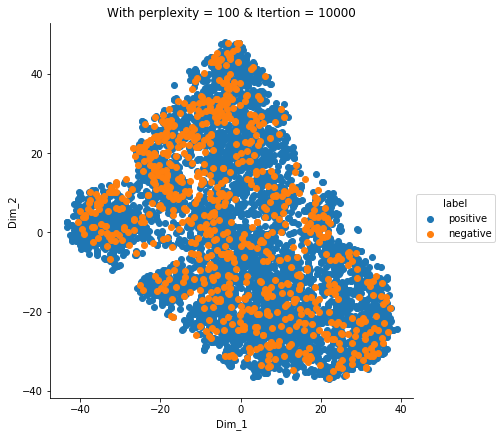

In [113]:
#Trying with 100 perplexity and 10000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=100,n_iter=10000)

tsne_data = model.fit_transform(standardized_data)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 100 & Itertion = 10000')
plt.show()

#### TFIDF-Word2Vec

In [116]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)


# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() 

In [117]:
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [118]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(tfidf_sent_vectors)
print(standardized_data.shape)

(5000, 50)


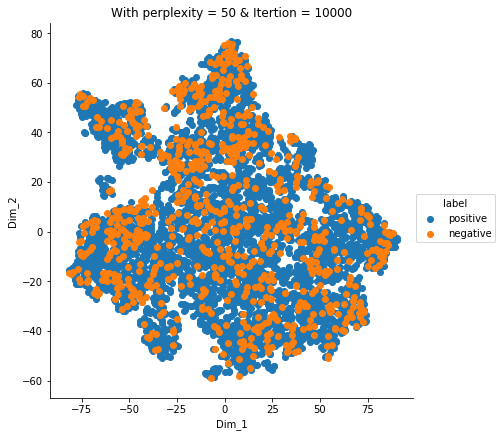

In [119]:
#Trying with 50 perplexity and 10000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=50,n_iter=10000)

tsne_data = model.fit_transform(standardized_data)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50 & Itertion = 10000')
plt.show()

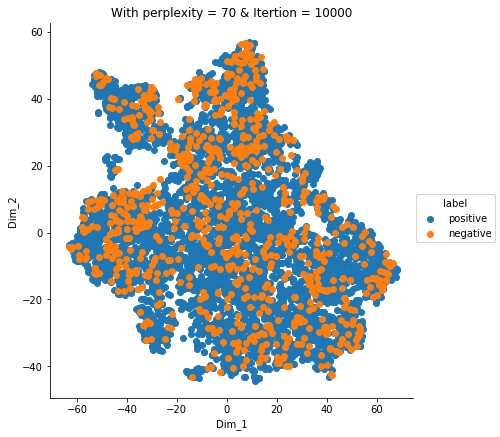

In [120]:
#Trying with 70 perplexity and 10000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=70,n_iter=10000)

tsne_data = model.fit_transform(standardized_data)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 70 & Itertion = 10000')
plt.show()

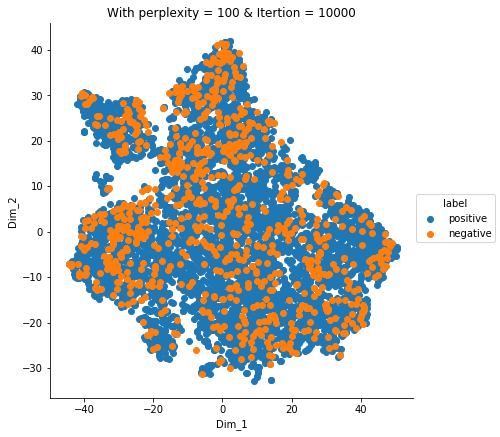

In [121]:
#Trying with 100 perplexity and 10000 iterations
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=123,perplexity=100,n_iter=10000)

tsne_data = model.fit_transform(standardized_data)
  
labels=final['Score']
# creating a new data frame which help us in ploting the result data
tsne_data_new = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data_new, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 100 & Itertion = 10000')
plt.show()

********************************************************************************************************************************************************